# Payroll Protection Program - New Orleans, LA
## Businesses that received < $150k

##### Data Source : https://home.treasury.gov/policy-issues/cares-act/assistance-for-small-businesses/sba-paycheck-protection-program-loan-level-data

In [1]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

pd.set_option('display.max_columns', 500)

In [ ]:
# To use Google Cloud to geocode addresses.

with open(r'C:\Users\Aaron\Documents\ML_Udacity\PPP\api_key.yaml') as f:
    key = yaml.safe_load(f)

In [5]:
# Import data set. Set includes total list of >$150k. 

mt150 = pd.read_csv('C:/Users/Aaron/Documents/ML_Udacity/PPP/All Data by State/All Data by State/150k plus/PPP Data 150k plus.csv')

In [266]:
mt150.BusinessName.fillna('NA', inplace=True)

In [262]:
mt150.head()

,LoanRange,BusinessName,Address,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD,NAICSCode_int,titles,LoanCategory
0,$5-10 million,"ARCTIC SLOPE NATIVE ASSOCIATION, LTD.",7000 Uula St,BARROW,AK,99723.0,813920.0,Non-Profit Organization,Unanswered,Unanswered,Unanswered,Y,295.0,04/14/2020,"National Cooperative Bank, National Association",AK - 00,813920,Professional Organizations,a
1,$1-2 million,"THE WASHINGTON COUNTY HEALTH CARE AUTHORITY, INC.",14600 SAINT STEPHENS AVE,CHATOM,AL,36518.0,813920.0,Corporation,Unanswered,Unanswered,Unanswered,NaN,201.0,04/10/2020,"The First, A National Banking Association",AL - 01,813920,Professional Organizations,c
2,"$350,000-1 million",AMERICAN PHARMACY COOPERATIVE INC,5601 SHIRLEY PARK DR,BESSEMER,AL,35022.0,813920.0,Non-Profit Organization,Unanswered,Unanswered,Unanswered,Y,56.0,04/06/2020,ServisFirst Bank,AL - 06,813920,Professional Organizations,d
3,"$150,000-350,000",STRATEGIC SYSTEMS INC,3434 Central Pkwy SW,DECATUR,AL,35603.0,813920.0,Corporation,Unanswered,Unanswered,Unanswered,NaN,37.0,04/10/2020,Renasant Bank,AL - 04,813920,Professional Organizations,e
4,$1-2 million,WORLDATWORK,14040 N Northsight Blvd,SCOTTSDALE,AZ,85260.0,813920.0,Non-Profit Organization,Unanswered,Unanswered,Unanswered,Y,86.0,04/06/2020,BMO Harris Bank National Association,AZ - 06,813920,Professional Organizations,c


In [278]:
mt150[mt150['BusinessName'].str.contains('DXC')]

,LoanRange,BusinessName,Address,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD,NAICSCode_int,titles,LoanCategory
37019,"$150,000-350,000","SDXCENTRAL , LLC",3511 RINGSBY CT,DENVER,CO,80216.0,518210.0,Limited Liability Company(LLC),White,Male Owned,Unanswered,NaN,14.0,04/13/2020,City National Bank,CO - 01,518210,"Data Processing, Hosting, and Related Services",e
123202,"$150,000-350,000",ADXCEL INC.,1244-B Quarry Lane,PLEASANTON,CA,94566.0,541511.0,Subchapter S Corporation,Unanswered,Unanswered,Unanswered,NaN,6.0,04/30/2020,Bank of the West,CA - 15,541511,Custom Computer Programming Services,e


In [6]:
print("Data Set: PPP More than $150k \nRows: {}\nCols: {}".format(mt150.shape[0], mt150.shape[1]))

Data Set: PPP More than $150k 
Rows: 661218
Cols: 16


In [ ]:
# mt150.head()

In [7]:
# Creates a new column 'NAICSCode_int' which converts 'NAICSCode' into integer.
# Changes datatypes of address to query Google.
# Adds NA for blank data.

mt150['NAICSCode_int'] = mt150['NAICSCode'].fillna('0').astype('int')
mt150['Zip'] = mt150['Zip'].fillna(' ').astype(str)
for col in ['Address', 'City', 'State']:
    mt150[col] = mt150[col].fillna('NA').astype('str')

In [4]:
def get_naics(naicscode):
    '''Requests NAICS api to retrieve code title. See http://api.naics.us/'''
    
    page = requests.get("http://api.naics.us/v0/q?year=2012&code={}".format(naicscode))
    naicspage = json.loads(page.content)
    try:
        title = naicspage['title']
    except:
        title = 'NAICS Not Found'
    return title

In [ ]:
## get_naics(mt150['NAICSCode_int'][0])

In [ ]:
# Retrieve all NAICS Titles

# mt150['NAICS_title'] = mt150['NAICSCode_int'].apply(lambda x: get_naics(x))

In [ ]:
# mt150.groupby('NAICSCode_int')['BusinessName'].nunique().sort_values(ascending=False)[:20]

In [10]:
# Create new frame with only unique NAICS codes.
# Will use unique codes to query NAICS

uqNAICSCodes = pd.DataFrame(mt150['NAICSCode_int'].unique(), columns=['NAICSCode_int'])

In [11]:
%%time
# Retrieve titles for Unique NAICS codes.

uqNAICSCodes['titles'] = uqNAICSCodes['NAICSCode_int'].apply(lambda x: get_naics(x))

Wall time: 2min 20s


In [12]:
# Merge Unique titles into main frame. 

mt150 = mt150.merge(uqNAICSCodes, on='NAICSCode_int')

In [13]:
# Split LoanRange into two: LoanCategory and LoanRange

mt150[['LoanCategory', 'LoanRange']] = mt150['LoanRange'].str.split(' ', 1, expand=True)

In [ ]:
#pd.DataFrame(mt150.groupby('titles')[['BusinessName', 'LoanCategory']].count().sort_values(by='BusinessName', ascending=False))[:25]

In [14]:
barplot_frame = pd.DataFrame(mt150.titles.value_counts().sort_values(ascending=False)[:6])

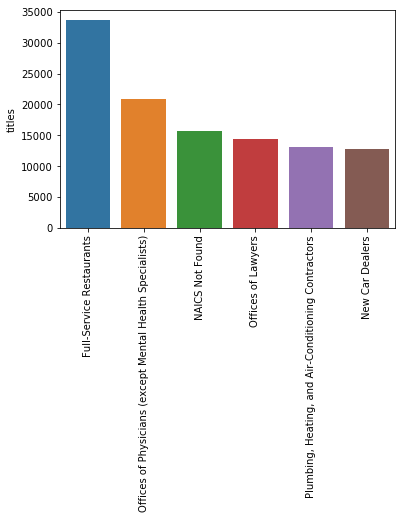

In [15]:
plot = sns.barplot(y = barplot_frame["titles"], x = barplot_frame.index)
plot.set_xticklabels(labels = barplot_frame.index, rotation=90)
plt.show()

In [ ]:
# catplot_frame.LoanRange.unique()

In [16]:
catplot_frame = pd.DataFrame(mt150.groupby(['titles', 'LoanRange']).agg({'BusinessName': 'count'}))
catplot_frame = catplot_frame.reset_index()
catplot_frame.shape

(4765, 3)

In [17]:
catplot_frame = catplot_frame.loc[catplot_frame['titles'].isin(barplot_frame.index)]

In [18]:
catplot_frame.head()

,titles,LoanRange,BusinessName
1655,Full-Service Restaurants,$1-2 million,1004
1656,Full-Service Restaurants,"$150,000-350,000",24631
1657,Full-Service Restaurants,$2-5 million,440
1658,Full-Service Restaurants,"$350,000-1 million",7351
1659,Full-Service Restaurants,$5-10 million,182


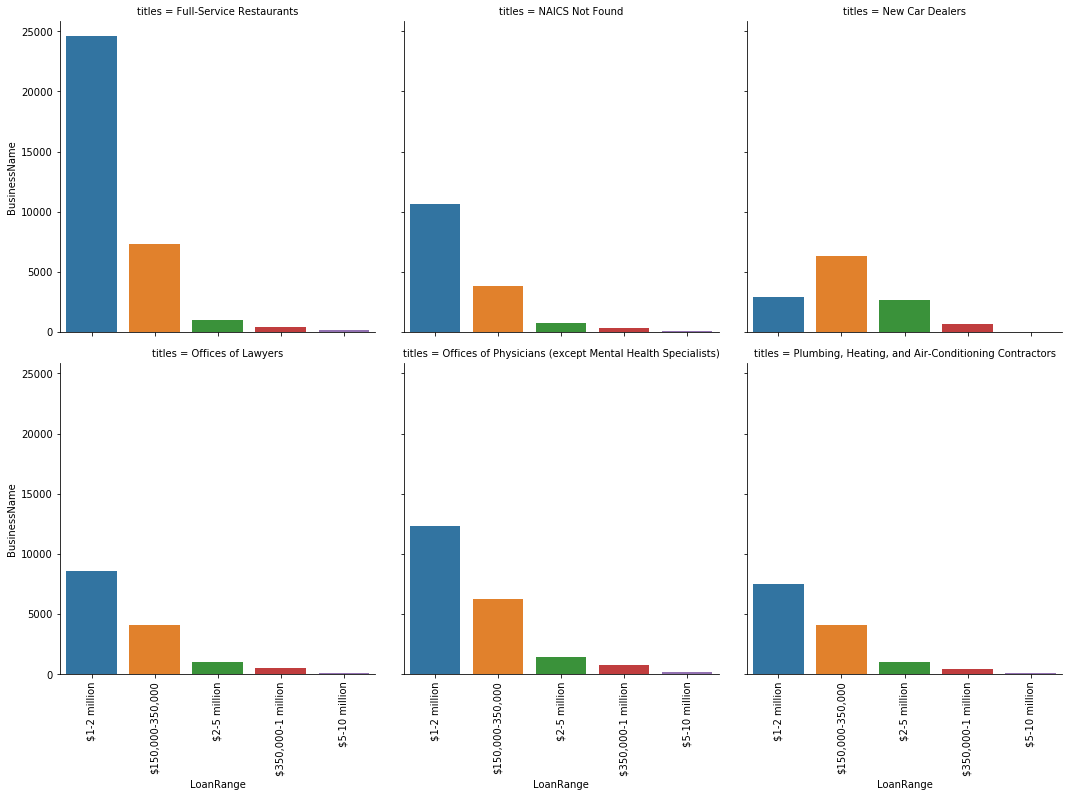

In [19]:
plot = sns.catplot(kind='bar', x = "LoanRange", y = "BusinessName", col = 'titles', data=catplot_frame, 
                   col_wrap=3, order=['$150,000-350,000', '$350,000-1 million', '$1-2 million', '$2-5 million','$5-10 million'])
plot.set_xticklabels(labels = catplot_frame["LoanRange"], rotation=90)
plt.show()

### New Orleans data Only

In [ ]:
nola = mt150.loc[mt150['City'] == 'NEW ORLEANS'].copy()

In [ ]:
# Joining address sections togther to query Google for geocoding. 

nola['full_address'] = nola[['Address', 'City', 'State', 'Zip']].agg(' '.join, axis=1)

In [ ]:
nola['request'] = pd.Series()

In [ ]:
nola.head()

In [ ]:
nola.shape

In [ ]:
def geocode(address):
    '''Takes address and outputs geocoordinates for mapping.
        Intended for output to create new column in original df'''
    
    url = 'https://maps.googleapis.com/maps/api/geocode/json'
    params = {'address':address, 'key':key}
    r = requests.get(url, params=params).json()['results']
    #loc = r[0]['geometry']['location']
    return r[0]

In [ ]:
# Testing function.

# geocode(nola.iloc[0]['full_address'])

In [ ]:
# Requesting Geocoding information for NOLA based businesses. 
# Don't Run again. Costs money.

# nola['request'] = nola['full_address'].apply(geocode)

In [32]:
# nola.to_pickle("nola.pkl")
nola = pd.read_pickle('nola.pkl')

In [34]:
nola.reset_index(inplace=True)

In [126]:
#nola.head()

In [113]:
def create_frame_w_requests(df):
    '''Creates new dataframe from requests data.
        Turns request JSON into additional columns of original Dataframe.
        To be merged in later.'''
    
    # Create Requests Frame
    rq_frame = pd.json_normalize(df['request'])

    # Create Address Components frame
    ad_comp_full = pd.DataFrame()
    for comp in rq_frame['address_components']:
        ad_comp = pd.json_normalize(comp)
        ad_comp['types'] = ad_comp['types'].apply(lambda x: x[0])
        ad_comp = ad_comp.T
        ad_comp.columns = ad_comp.loc['types']
        ad_comp = ad_comp.loc[['long_name']].reset_index()
        ad_comp_full = ad_comp_full.append(ad_comp, ignore_index=True)

    # Merge two frames above into one
    rq_frame = rq_frame.merge(ad_comp_full, left_index = True, right_index = True)
    return rq_frame

In [114]:
# Runs create_frame_w_requests() function on each row of dataframe. Creates

rq_frame = create_frame_w_requests(nola).drop('address_components', axis=1)

In [ ]:
# nola = nola.reset_index(inplace = True)

In [119]:
#rq_frame

In [116]:
# Merge new requests frame into original

nola = nola.merge(rq_frame, left_index = True, right_index = True)

In [118]:
#nola

In [120]:
# Create new frame with only unique NAICS codes.

nola['NAICSCode_int'] = nola['NAICSCode'].fillna('0').astype('int')
uqNAICSCodes = pd.DataFrame(nola['NAICSCode_int'].unique(), columns=['NAICSCode_int'])

In [121]:
%%time
# Retrieve titles for Unique NAICS codes.

uqNAICSCodes['titles'] = uqNAICSCodes['NAICSCode_int'].apply(lambda x: get_naics(x))

Wall time: 36.4 s


In [122]:
# Merge Unique titles into main frame. 

nola = nola.merge(uqNAICSCodes, on='NAICSCode_int')

In [125]:
nola.to_pickle('nola_postReq.pkl')

In [257]:
nola = pd.read_pickle('nola_postReq.pkl')

In [198]:
nola.head()

,index_x,LoanRange,BusinessName,Address,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD,NAICSCode_int,full_address,request,formatted_address,place_id,types,geometry.bounds.northeast.lat,geometry.bounds.northeast.lng,geometry.bounds.southwest.lat,geometry.bounds.southwest.lng,geometry.location.lat,geometry.location.lng,geometry.location_type,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng,partial_match,plus_code.compound_code,plus_code.global_code,postcode_localities,index_y,subpremise,premise,street_number,route,neighborhood,locality,administrative_area_level_2,administrative_area_level_1,country,postal_code,administrative_area_level_3,postal_code_suffix,political,establishment,titles
0,264508,a $5-10 million,ADAMS AND REESE LLP,701 Poydras St Ste 4500,NEW ORLEANS,LA,70139.0,541110.0,Limited Liability Partnership,Unanswered,Unanswered,Unanswered,NaN,458.0,04/13/2020,Regions Bank,LA - 02,541110,701 Poydras St Ste 4500 NEW ORLEANS LA 70139.0,"{'address_components': [{'long_name': '4500', ...","One Shell Square, 701 Poydras St #4500, New Or...",EkJPbmUgU2hlbGwgU3F1YXJlLCA3MDEgUG95ZHJhcyBTdC...,[subpremise],29.950700,-90.070402,29.949859,-90.071706,29.950304,-90.071350,ROOFTOP,29.951629,-90.069705,29.948931,-90.072403,NaN,NaN,NaN,NaN,long_name,4500,One Shell Square,701,Poydras Street,Central Business District,New Orleans,Orleans Parish,Louisiana,United States,70139,NaN,NaN,NaN,NaN,Offices of Lawyers
1,264557,a $5-10 million,"MCGLINCHEY STAFFORD, PLLC",601 POYDRAS ST 12FL,NEW ORLEANS,LA,70130.0,541110.0,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,345.0,04/15/2020,"JPMorgan Chase Bank, National Association",LA - 02,541110,601 POYDRAS ST 12FL NEW ORLEANS LA 70130.0,"{'address_components': [{'long_name': '12FL', ...","Pan American Life Center, 601 Poydras St #12FL...",EkpQYW4gQW1lcmljYW4gTGlmZSBDZW50ZXIsIDYwMSBQb3...,[subpremise],29.950168,-90.069278,29.949544,-90.070138,29.949959,-90.069677,ROOFTOP,29.951205,-90.068359,29.948507,-90.071057,True,NaN,NaN,NaN,long_name,12FL,Pan American Life Center,601,Poydras Street,Central Business District,New Orleans,Orleans Parish,Louisiana,United States,70130,NaN,NaN,NaN,NaN,Offices of Lawyers
2,264564,a $5-10 million,"PHELPS DUNBAR, LLP",365 CANAL ST Suite 2000,NEW ORLEANS,LA,70130.0,541110.0,Limited Liability Partnership,Unanswered,Unanswered,Unanswered,NaN,397.0,04/09/2020,Hancock Whitney Bank,LA - 02,541110,365 CANAL ST Suite 2000 NEW ORLEANS LA 70130.0,"{'address_components': [{'long_name': '2000', ...","365 Canal St #2000, New Orleans, LA 70130, USA",Ei4zNjUgQ2FuYWwgU3QgIzIwMDAsIE5ldyBPcmxlYW5zLC...,[subpremise],NaN,NaN,NaN,NaN,29.951306,-90.065479,ROOFTOP,29.952655,-90.064130,29.949957,-90.066828,True,NaN,NaN,NaN,long_name,2000,NaN,365,Canal Street,French Quarter,New Orleans,Orleans Parish,Louisiana,United States,70130,NaN,NaN,NaN,NaN,Offices of Lawyers
3,264672,b $2-5 million,DEUTSCH KERRIGAN LLP,755 Market Street,NEW ORLEANS,LA,70130.0,541110.0,Partnership,Unanswered,Unanswered,Unanswered,NaN,120.0,04/05/2020,IBERIABANK,LA - 02,541110,755 Market Street NEW ORLEANS LA 70130.0,"{'address_components': [{'long_name': '755', '...","755 Market St, New Orleans, LA 70130, USA",Eik3NTUgTWFya2V0IFN0LCBOZXcgT3JsZWFucywgTEEgNz...,[street_address],NaN,NaN,NaN,NaN,29.930895,-90.069548,RANGE_INTERPOLATED,29.932244,-90.068199,29.929546,-90.070897,True,NaN,NaN,NaN,long_name,NaN,NaN,755,Market Street,Lower Garden District,New Orleans,Orleans Parish,Louisiana,United States,70130,NaN,4623,NaN,NaN,Offices of Lawyers
4,264704,b $2-5 million,"GALLOWAY, JOHNSON, THOMPKINS, BURR, SMITH, APLC",701 Poydras Street 40th Floor,NEW ORLEANS,LA,70139.0,541110.0,Corporation,Unanswered,Unanswered,Unanswered,NaN,248.0,04/13/2020,Fidelity Bank,LA - 02,541110,701 Poydras Street 40th Floor NEW ORLEANS LA 7...,"{'address_components': [{'long_name': '701', '...",

In [128]:
barplot_frame = pd.DataFrame(nola.titles.value_counts().sort_values(ascending=False)[:6])

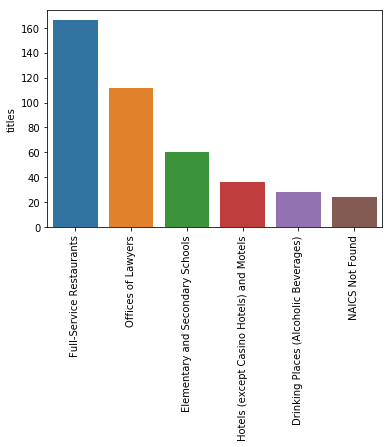

In [129]:
plot = sns.barplot(y = barplot_frame["titles"], x = barplot_frame.index)
plot.set_xticklabels(labels = barplot_frame.index, rotation=90)
plt.show()

In [130]:
catplot_frame = pd.DataFrame(nola.groupby(['titles', 'LoanRange']).agg({'BusinessName': 'count'}))
catplot_frame = catplot_frame.reset_index()
catplot_frame.shape

(486, 3)

In [131]:
catplot_frame = catplot_frame.loc[catplot_frame['titles'].isin(barplot_frame.index)]

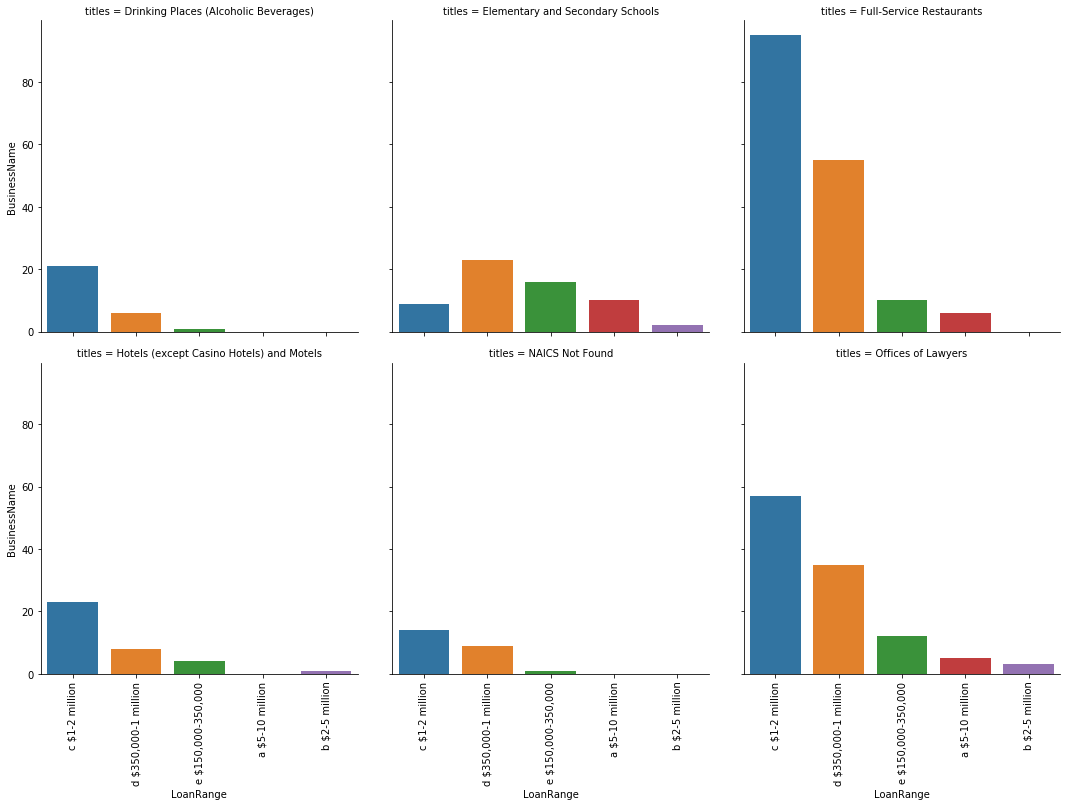

In [132]:
plot = sns.catplot(kind='bar', x = "LoanRange", y = "BusinessName", col = 'titles', data=catplot_frame, 
                   col_wrap=3, order=['e $150,000-350,000', 'd $350,000-1 million', 'c $1-2 million', 'b $2-5 million','a $5-10 million'])
plot.set_xticklabels(labels = catplot_frame["LoanRange"], rotation=90)
plt.show()

## Mapping PPP Businesses

In [225]:
import folium as flm
from folium import plugins

In [258]:
nola[['Loan_cat','Loan_money_range']] = nola.LoanRange.str.split(' ', 1, expand=True)

In [259]:
nola['marker_color'] = pd.Series()

C:\Users\Aaron\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [260]:
# Creating Loan Category colors for map markers.

loancats = ['a', 'b', 'c', 'd', 'e']
loancolors = ['red', 'orange', 'lightgreen', 'green', 'blue']
catsColors = zip(loancats, loancolors)

for cat, color in catsColors:
    nola.loc[nola['Loan_cat'] == cat, 'marker_color'] = color

In [261]:
nola.head()

,index_x,LoanRange,BusinessName,Address,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD,NAICSCode_int,full_address,request,formatted_address,place_id,types,geometry.bounds.northeast.lat,geometry.bounds.northeast.lng,geometry.bounds.southwest.lat,geometry.bounds.southwest.lng,geometry.location.lat,geometry.location.lng,geometry.location_type,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng,partial_match,plus_code.compound_code,plus_code.global_code,postcode_localities,index_y,subpremise,premise,street_number,route,neighborhood,locality,administrative_area_level_2,administrative_area_level_1,country,postal_code,administrative_area_level_3,postal_code_suffix,political,establishment,titles,Loan_cat,Loan_money_range,marker_color
0,264508,a $5-10 million,ADAMS AND REESE LLP,701 Poydras St Ste 4500,NEW ORLEANS,LA,70139.0,541110.0,Limited Liability Partnership,Unanswered,Unanswered,Unanswered,NaN,458.0,04/13/2020,Regions Bank,LA - 02,541110,701 Poydras St Ste 4500 NEW ORLEANS LA 70139.0,"{'address_components': [{'long_name': '4500', ...","One Shell Square, 701 Poydras St #4500, New Or...",EkJPbmUgU2hlbGwgU3F1YXJlLCA3MDEgUG95ZHJhcyBTdC...,[subpremise],29.950700,-90.070402,29.949859,-90.071706,29.950304,-90.071350,ROOFTOP,29.951629,-90.069705,29.948931,-90.072403,NaN,NaN,NaN,NaN,long_name,4500,One Shell Square,701,Poydras Street,Central Business District,New Orleans,Orleans Parish,Louisiana,United States,70139,NaN,NaN,NaN,NaN,Offices of Lawyers,a,$5-10 million,red
1,264557,a $5-10 million,"MCGLINCHEY STAFFORD, PLLC",601 POYDRAS ST 12FL,NEW ORLEANS,LA,70130.0,541110.0,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,345.0,04/15/2020,"JPMorgan Chase Bank, National Association",LA - 02,541110,601 POYDRAS ST 12FL NEW ORLEANS LA 70130.0,"{'address_components': [{'long_name': '12FL', ...","Pan American Life Center, 601 Poydras St #12FL...",EkpQYW4gQW1lcmljYW4gTGlmZSBDZW50ZXIsIDYwMSBQb3...,[subpremise],29.950168,-90.069278,29.949544,-90.070138,29.949959,-90.069677,ROOFTOP,29.951205,-90.068359,29.948507,-90.071057,True,NaN,NaN,NaN,long_name,12FL,Pan American Life Center,601,Poydras Street,Central Business District,New Orleans,Orleans Parish,Louisiana,United States,70130,NaN,NaN,NaN,NaN,Offices of Lawyers,a,$5-10 million,red
2,264564,a $5-10 million,"PHELPS DUNBAR, LLP",365 CANAL ST Suite 2000,NEW ORLEANS,LA,70130.0,541110.0,Limited Liability Partnership,Unanswered,Unanswered,Unanswered,NaN,397.0,04/09/2020,Hancock Whitney Bank,LA - 02,541110,365 CANAL ST Suite 2000 NEW ORLEANS LA 70130.0,"{'address_components': [{'long_name': '2000', ...","365 Canal St #2000, New Orleans, LA 70130, USA",Ei4zNjUgQ2FuYWwgU3QgIzIwMDAsIE5ldyBPcmxlYW5zLC...,[subpremise],NaN,NaN,NaN,NaN,29.951306,-90.065479,ROOFTOP,29.952655,-90.064130,29.949957,-90.066828,True,NaN,NaN,NaN,long_name,2000,NaN,365,Canal Street,French Quarter,New Orleans,Orleans Parish,Louisiana,United States,70130,NaN,NaN,NaN,NaN,Offices of Lawyers,a,$5-10 million,red
3,264672,b $2-5 million,DEUTSCH KERRIGAN LLP,755 Market Street,NEW ORLEANS,LA,70130.0,541110.0,Partnership,Unanswered,Unanswered,Unanswered,NaN,120.0,04/05/2020,IBERIABANK,LA - 02,541110,755 Market Street NEW ORLEANS LA 70130.0,"{'address_components': [{'long_name': '755', '...","755 Market St, New Orleans, LA 70130, USA",Eik3NTUgTWFya2V0IFN0LCBOZXcgT3JsZWFucywgTEEgNz...,[street_address],NaN,NaN,NaN,NaN,29.930895,-90.069548,RANGE_INTERPOLATED,29.932244,-90.068199,29.929546,-90.070897,True,NaN,NaN,NaN,long_name,NaN,NaN,755,Market Street,Lower Garden District,New Orleans,Orleans Parish,Louisiana,United States,70130,NaN,4623,NaN,NaN,Offices of Lawyers,b,$2-5 million,orange
4,264704,b $2-5 million,"GALLOWAY, JOHNSON, THOMPKINS, BURR, SMITH, APLC",701 Poydras Street 40th Floor,NEW ORLEANS,LA,70139.0,541110.0,Corporation,Unanswered,Unanswered,Unanswered,NaN,248.0,04/13/2020,Fidelity B

In [220]:
# Instatiate Map - Using first location in the list to focus New Orleans.

m = flm.Map(location=[nola['geometry.location.lat'][0], nola['geometry.location.lng'][0]],
           zoom_start=13)

In [221]:
def add_markers(x):
    '''Add markers to map. When marker clicked, popup will give business name
    and loan range. Color given above.'''
    
    popup = str(x['BusinessName']) + '<br>' + str(x['Loan_money_range'])
    marker_color = x['marker_color']
    flm.Marker([x['geometry.location.lat'], x['geometry.location.lng']], 
               popup=popup,
              icon=flm.Icon(color=marker_color)).add_to(m)

nola.apply(add_markers, axis=1);

In [222]:
m.save('PPPNola_Over150k.html')

# heatmap

In [281]:
# Instatiate Map - Using first location in the list to focus New Orleans.

m = flm.Map(location=[nola['geometry.location.lat'][0], nola['geometry.location.lng'][0]],
           zoom_start=13)

In [235]:
# def add_Circlemarkers(x):
#     '''Creates circle markers for map.
#     '''
    
#     popup = str(x['BusinessName']) + '<br>' + str(x['Loan_money_range'])
#     flm.CircleMarker([x['geometry.location.lat'], x['geometry.location.lng']], 
#                popup=popup,
#                radius=0,
#                fill_color="#3db7e4").add_to(m)

# nola.apply(add_Circlemarkers, axis=1);

In [282]:
# Create heatmap matrix using lat and lng. Add heatmap to map.

heatmap_mat = nola[['geometry.location.lat', 'geometry.location.lng']].to_numpy()
m.add_child(plugins.HeatMap(heatmap_mat, radius=15))  #

In [250]:
m.save('PPPNola_Over150k_heatmap.html')

In [288]:
len(nola.titles.unique())

310

In [297]:
nola.titles.value_counts()[:10]

Full-Service Restaurants                                    166
Offices of Lawyers                                          112
Elementary and Secondary Schools                             60
Hotels (except Casino Hotels) and Motels                     36
Drinking Places (Alcoholic Beverages)                        28
NAICS Not Found                                              24
Limited-Service Restaurants                                  21
Engineering Services                                         19
Offices of Physicians (except Mental Health Specialists)     16
Architectural Services                                       15
Name: titles, dtype: int64

In [298]:
nola[nola['titles'] == 'NAICS Not Found']

,index_x,LoanRange,BusinessName,Address,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD,NAICSCode_int,full_address,request,formatted_address,place_id,types,geometry.bounds.northeast.lat,geometry.bounds.northeast.lng,geometry.bounds.southwest.lat,geometry.bounds.southwest.lng,geometry.location.lat,geometry.location.lng,geometry.location_type,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng,partial_match,plus_code.compound_code,plus_code.global_code,postcode_localities,index_y,subpremise,premise,street_number,route,neighborhood,locality,administrative_area_level_2,administrative_area_level_1,country,postal_code,administrative_area_level_3,postal_code_suffix,political,establishment,titles,Loan_cat,Loan_money_range,marker_color
612,265309,c $1-2 million,LYCEE FRANCAIS DE LA NOUVELLE ORLEANS INC,5951 PATTON ST,NEW ORLEANS,LA,70115.0,NaN,Non-Profit Organization,Unanswered,Unanswered,Unanswered,Y,136.0,05/03/2020,Hancock Whitney Bank,LA - 01,0,5951 PATTON ST NEW ORLEANS LA 70115.0,"{'address_components': [{'long_name': '5951', ...","5951 Patton St, New Orleans, LA 70115, USA",ChIJa1zxNfukIIYRZolktciluVQ,"[establishment, point_of_interest, school]",NaN,NaN,NaN,NaN,29.920432,-90.121425,ROOFTOP,29.921781,-90.120076,29.919083,-90.122774,NaN,"WVCH+5C New Orleans, LA, USA",76XFWVCH+5C,NaN,long_name,NaN,NaN,5951,Patton Street,West Riverside,New Orleans,Orleans Parish,Louisiana,United States,70115,NaN,NaN,NaN,NaN,NAICS Not Found,c,$1-2 million,lightgreen
613,265745,"d $350,000-1 million","ADVOCATES FOR INNOVATIVE SCHOOLS, INC.",8550 CURRAN BLVD,NEW ORLEANS,LA,70127.0,NaN,Non-Profit Organization,Unanswered,Male Owned,Unanswered,Y,70.0,05/03/2020,Hancock Whitney Bank,LA - 02,0,8550 CURRAN BLVD NEW ORLEANS LA 70127.0,"{'address_components': [{'long_name': '8550', ...","8550 Curran Blvd, New Orleans, LA 70127, USA",ChIJIzdJDXQCnogR6pd2FAiY-gw,[premise],30.039544,-89.995401,30.038540,-89.996426,30.038988,-89.995993,ROOFTOP,30.040391,-89.994565,30.037693,-89.997263,NaN,NaN,NaN,NaN,long_name,NaN,NaN,8550,Curran Boulevard,New Orleans East Area,New Orleans,Orleans Parish,Louisiana,United States,70127,NaN,NaN,NaN,NaN,NAICS Not Found,d,"$350,000-1 million",green
614,265756,"d $350,000-1 million","AIMS COMPOSITES, LLC",330 CARONDELET STREET,NEW ORLEANS,LA,70130.0,NaN,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,27.0,05/03/2020,Hancock Whitney Bank,LA - 02,0,330 CARONDELET STREET NEW ORLEANS LA 70130.0,"{'address_components': [{'long_name': '330', '...","330 Carondelet St, New Orleans, LA 70130, USA",ChIJ10fQNQumIIYRJo6_V2MI8Ms,[street_address],NaN,NaN,NaN,NaN,29.951233,-90.071284,ROOFTOP,29.952582,-90.069935,29.949884,-90.072633,True,"XW2H+FF New Orleans, LA, USA",76XFXW2H+FF,NaN,long_name,NaN,NaN,330,Carondelet Street,Central Business District,New Orleans,Orleans Parish,Louisiana,United States,70130,NaN,3144,NaN,NaN,NAICS Not Found,d,"$350,000-1 million",green
615,266005,"d $350,000-1 million","BLAKE JONES LAW FIRM, LLC",701 POYDRAS ST,NEW ORLEANS,LA,70139.0,NaN,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,21.0,05/03/2020,Hancock Whitney Bank,LA - 02,0,701 POYDRAS ST NEW ORLEANS LA 70139.0,{'address_components': [{'long_name': 'One She...,"One Shell Square, 701 Poydras St, New Orleans,...",ChIJQVyTt3SmIIYR5wM0jYaxUmA,[premise],29.950700,-90.070402,29.949859,-90.071706,29.950304,-90.071350,ROOFTOP,29.951629,-90.069705,29.948931,-90.072403,NaN,NaN,NaN,NaN,long_name,NaN,One Shell Square,701,Poydras Street,Central Business District,New Orleans,Orleans Parish,Louisiana,United States,70139,NaN,NaN,NaN,NaN,NAICS Not Found,d,"$350,000-1 million",green
616,268786,"e $150,000-350,000",ARICI DD LLC,123 CARONDELET ST,NEW ORLEANS,LA,70130.0,NaN,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,26.0,05/03/2020,Hancock Whitney Bank,LA - 02,0,123 CARONDELET ST NEW

## Conclusion:  

Heatmap shows the highest grouping of businesses that received more than $150k in PPP money located in the CBD (big surprise). Another group located in midcity. Highest PPP money loan range receivers not centralized anywhere specifically. 
For an in depth look at who the businesses receiving this money are, Check the interactive 'PPPNola_Over150k.html' map exported to this folder. 


Further improvment on this analysis would use the "Titles" column requested from the NAICS website to categorize businesses. This would take manual work, however, to try to collapse these titles into less, broader categories. 